In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
from deepsudoku import load_supervised_data, metrics_and_callbacks, REPO_PATH, DIFFICULTIES
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(REPO_PATH)

BATCHSIZE = 256 * 4

2023-07-27 10:57:11.629725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 10:57:13.089083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = tf.keras.models.load_model(
    "models/final_supervised",
    custom_objects={"SudokuWinRate": metrics_and_callbacks.SudokuWinRate}
)

2023-07-27 10:57:15.961989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 10:57:16.279637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 10:57:16.280216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
test_data_by_difficulty = load_supervised_data.get_data_by_difficulty("test")

metric = metrics_and_callbacks.SudokuWinRate()

results = {}

for difficulty, data in test_data_by_difficulty.items():

    metric.reset_state()

    preprocessed = load_supervised_data.get_tf_dataset(*data).batch(BATCHSIZE)

    preds = model.predict(preprocessed, verbose = True)

    labels = data[1] - 1

    metric.update_state(labels, preds)

    results[difficulty] = metric.result().numpy()

results

2023-07-27 10:57:21.075372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [25000,9,9]
	 [[{{node Placeholder/_1}}]]
2023-07-27 10:57:23.249461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-27 10:57:25.152078: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-27 10:57:25.152643: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-27 10:57:25.152668: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-27 10:57:25.153

 4/53 [=>............................] - ETA: 2s

2023-07-27 10:57:29.396169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [53500,9,9]
	 [[{{node Placeholder/_1}}]]


 4/25 [===>..........................] - ETA: 1s

2023-07-27 10:57:33.112734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [25000,9,9]
	 [[{{node Placeholder/_1}}]]


 4/29 [===>..........................] - ETA: 1s

2023-07-27 10:57:34.619346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [29000,9,9]
	 [[{{node Placeholder/_1}}]]


 4/49 [=>............................] - ETA: 2s

2023-07-27 10:57:36.977007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,9,9]
	 [[{{node Placeholder/_1}}]]


49/49 [==============================] - 4s 89ms/step


{'easy': 1.0,
 'medium': 0.9998131,
 'hard': 0.99868,
 'extreme': 0.99531037,
 'insane': 0.98966}

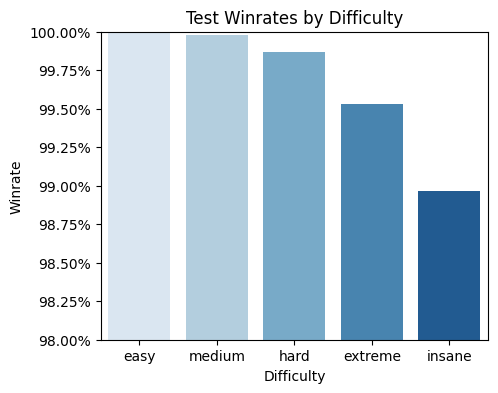

In [4]:
import matplotlib.ticker as mticker

df = pd.DataFrame(list(results.items()), columns=['Difficulty', 'Winrate'])

@np.vectorize
def sort_func(i):
    
    if i.lower() == "train":
        return 0
    
    return DIFFICULTIES.index(i.lower()) + 1

df = df.sort_values("Difficulty", key = sort_func)

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(x='Difficulty', y='Winrate', data=df, palette='Blues')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.ylim(0.98, 1.0)  # Adjust as needed
plt.title('Test Winrates by Difficulty')
plt.show()

In [5]:
first = pd.read_csv("logs/supervised/until_epoch_72.csv")
second = pd.read_csv("logs/supervised/after_epoch_72.csv")


df = pd.concat((first, second))

df = df.rename(columns= {"sudoku_win_rate": "sudoku_win_rate/train"})

val_win_rates = [i for i in df.columns if "win_rate" in i]

df = df.rename(columns= {i: i[i.find('/')+1:] for i in val_win_rates})

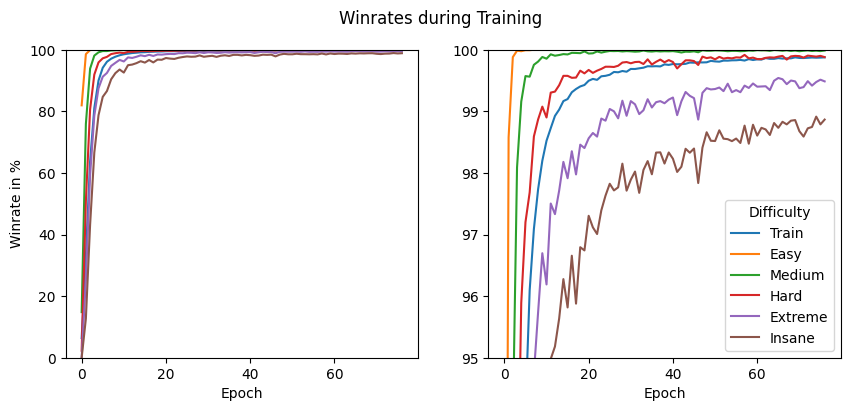

In [6]:
plot_df = df.drop(columns=["accuracy","loss"])
plot_df.columns = [i.title() for i in plot_df.columns]

df_melt = plot_df.melt('Epoch', var_name='Difficulty', value_name='Winrate')

@np.vectorize
def sort_func(i):
    
    if i.lower() == "train":
        return 0
    
    return DIFFICULTIES.index(i.lower()) + 1

df_melt = df_melt.sort_values("Difficulty", key = sort_func)
df_melt.Winrate *= 100

plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2,1)
sns.lineplot(data=df_melt, x="Epoch", y="Winrate", hue="Difficulty", legend= None)
plt.ylim(0, 100)
plt.ylabel("Winrate in %")
# Plotting with y-axis limits from 0.95 to 1
ax = plt.subplot(1, 2,2)
sns.lineplot(data=df_melt, x="Epoch", y="Winrate", hue="Difficulty")
plt.ylim(95, 100)
plt.ylabel(None)
plt.suptitle("Winrates during Training")
plt.show()

In [7]:
data = pd.read_csv("data/to_beat.csv")
quizzes = data.quizzes.apply(lambda x : np.array([int(c) for c in x]).reshape(9,9)) 
solutions = data.solutions.apply(lambda x : np.array([int(c) for c in x]).reshape(9,9)) 
quizzes = np.stack(quizzes)
solutions = np.stack(solutions)

ds = load_supervised_data.get_tf_dataset(quizzes, solutions).batch(32)

preds = model.predict(ds)
preds = np.argmax(preds, axis= -1) + 1

1/1 [==============================] - 0s 188ms/step


2023-07-27 10:57:42.133641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [30,9,9]
	 [[{{node Placeholder/_1}}]]


In [8]:
(preds  == solutions).mean()

0.3522633744855967

In [9]:
solutions[0]

array([[4, 8, 9, 5, 3, 2, 7, 6, 1],
       [7, 1, 3, 4, 8, 6, 5, 9, 2],
       [5, 6, 2, 9, 1, 7, 8, 3, 4],
       [2, 5, 8, 3, 4, 1, 9, 7, 6],
       [6, 3, 1, 7, 5, 9, 2, 4, 8],
       [9, 4, 7, 2, 6, 8, 1, 5, 3],
       [1, 2, 5, 6, 7, 3, 4, 8, 9],
       [8, 7, 6, 1, 9, 4, 3, 2, 5],
       [3, 9, 4, 8, 2, 5, 6, 1, 7]])

In [10]:
quizzes[0]

array([[0, 8, 0, 0, 3, 2, 0, 0, 1],
       [7, 0, 3, 0, 8, 0, 0, 0, 2],
       [5, 0, 0, 0, 0, 7, 0, 3, 0],
       [0, 5, 0, 0, 0, 1, 9, 7, 0],
       [6, 0, 0, 7, 0, 9, 0, 0, 8],
       [0, 4, 7, 2, 0, 0, 0, 5, 0],
       [0, 2, 0, 6, 0, 0, 0, 0, 9],
       [8, 0, 0, 0, 9, 0, 3, 0, 5],
       [3, 0, 0, 8, 2, 0, 0, 1, 0]])

In [11]:
preds[0] + 1

array([[ 5,  6,  4,  7,  6,  6,  3,  7,  2],
       [ 8,  6,  4,  9,  9,  9,  6,  7,  2],
       [ 6,  2,  5, 10,  3,  5,  6, 10,  2],
       [ 7,  6,  2,  4,  4,  4, 10,  8,  9],
       [ 7,  6,  2,  9,  9, 10,  2,  5,  3],
       [10,  9,  8,  3,  5,  2,  7,  6,  4],
       [ 3,  2,  6,  7,  7,  4,  8,  2, 10],
       [ 9,  9,  2,  9, 10,  8,  4,  2,  6],
       [ 4,  4,  6,  9, 10,  8,  5,  2,  7]])